In [1]:
# %load ../startup.py
import os,sys
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

os.environ['PYTHONPATH']=os.environ.get('LIB')
if not os.environ.get('LIB') in sys.path: 
    sys.path.insert(0,os.environ.get('LIB'))

DAT_DIR = os.environ.get('DAT_DIR')    

%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
%load_ext rpy2.ipython

import matplotlib.text as text
import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import sys
import rpy2 
import os 
from matplotlib import gridspec
from scipy.interpolate import splev, splrep
import xlwt
import seaborn as sns
from scipy import stats
import rpy2.robjects.packages as rpackages
import seaborn as sns
from statsmodels import robust


from heprnhci.db.mongo import *


from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>")) # increase jupyter screen width to 100%
pd.options.display.max_colwidth = 500
pd.set_option('display.precision',2)

HCI=openMongo(db=os.environ.get('MONGO_HCIDB'),host=os.environ.get('MONGO_HOST'),auth=False)


# Goal

Calcualte the administered equivalent dose (AED) 

In vitro conc of hepatocytes is venous conc in rat at time-matched 
time points (time-matched)

* Dose_ivt at ti = Cmax at ti 
* Dose_ivt at ti = Cave at ti 
* Dose_ivt * ti  = AUCv at ti 

In vitro conc of hepatocytes is venous conc in rats time-averaged across 
T (time-averaged)

* Dose_ivt at ti = Cmax from 0 to Ti 
* Dose_ivt at ti = Cave from 0 to Ti 
* Dose_ivt * ti  = AUCv at Ti 

In vitro conc of hepatocytes is venous conc in rats (final-time-matched)

* Dose_ivt at ti = Cmax from Ti-ti:Ti 
* Dose_ivt at ti = Cave from Ti-ti:Ti 
* Dose_ivt * ti  = mean AUCv Ti-ti:Ti 



In [2]:
from tk.httk import *

/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [10]:
import seaborn as sns
sns.set(style='whitegrid')

In [6]:
#HCI.heprn_iviv.rename('heprn_iviv_0')

{u'ok': 1.0}

# Test out for APAP & Fix Py3 issues

In [3]:
X_10 = solvePBTK('103-90-2',days=14,dose=10,species='Rat',rest_clear=True)#.set_index('time')
X_10.head()

,time,Agutlumen,Cart,Cven,Clung,Cgut,Cliver,Ckidney,Crest,Ametabolized,Atubules,Cplasma,AUC_v
0,0.00e+00,16.54,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
1,1.00e-08,16.54,1.87e-25,1.91e-14,8.54e-18,1.34e-03,6.47e-09,7.44e-31,4.08e-32,1.49e-16,6.18e-43,1.91e-14,9.54e-23
2,1.04e-02,9.59,1.19e+01,1.19e+01,1.90e+01,8.10e+01,8.24e+01,3.86e+01,9.50e+00,3.61e+00,9.48e-02,1.19e+01,7.47e-02
3,2.08e-02,5.56,1.40e+01,1.40e+01,2.24e+01,5.93e+01,6.25e+01,4.65e+01,1.29e+01,7.10e+00,2.87e-01,1.40e+01,2.15e-01
4,3.12e-02,3.22,1.26e+01,1.26e+01,2.00e+01,4.21e+01,4.53e+01,4.19e+01,1.20e+01,9.69e+00,4.81e-01,1.26e+01,3.55e-01


In [4]:
calcOralEquiv('103-90-2',list(np.array([1.0])),units_out='mg')

array([12.64090507])

In [5]:
X=simIVIVEdata('103-90-2',species='Rat',
                OD=[1.0,10.0],
                 rest_clear=False,
                IVt_days=[3.0/24,6.0/24,0.5,10],
                IVv_days=[2.0,7.0],
                replace=True
               )
IV0=pd.DataFrame(X['ivivd'])

In [38]:
IV0.head()

,casrn,days_ivt,days_ivv,dose_ivt,dose_ivv,dose_metric,method,species
0,103-90-2,0.12,2.0,0.06,1.0,auc,time-matched,Rat
1,103-90-2,0.12,2.0,0.13,1.0,auc,time-averaged,Rat
2,103-90-2,0.12,2.0,0.13,1.0,auc,time-final-matched,Rat
3,103-90-2,0.25,2.0,0.06,1.0,auc,time-matched,Rat
4,103-90-2,0.25,2.0,0.13,1.0,auc,time-averaged,Rat


/usr/lib/python3/dist-packages/numpy/lib/function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/usr/lib/python3/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


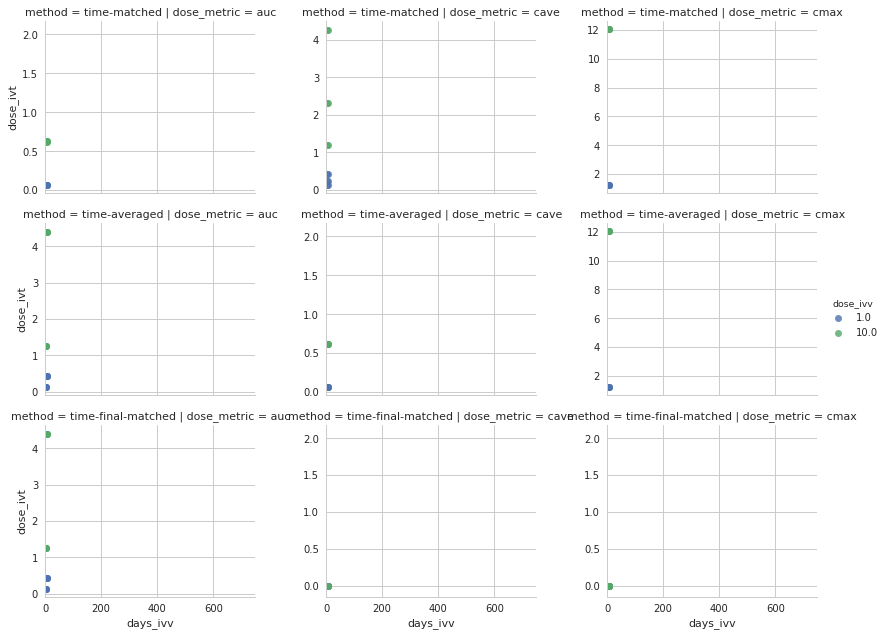

In [44]:
g = sns.lmplot('days_ivv','dose_ivt',IV0,
           col='dose_metric',row='method',
           hue='dose_ivv',
           fit_reg=True,lowess=True,x_ci=None,
           size=3,aspect=1.3,
           sharey=False
          )
g.set(xlim=[0,750])

In [56]:
X=simIVIVEdata('103-90-2',species='Rat',
                OD=[1,10],
                 rest_clear=True,
                IVt_days=[3.0/24,6.0/24,0.5,1,2,3,4,5,6,7],
                IVv_days=[2,7,14,30,60,90,182,365,730,1095],
#                  dbc_sav=HCI.heprn_iviv, 
                replace=True
               )
IV1=pd.DataFrame(X['ivivd'])

In [57]:
IV1.head().T

,0,1,2,3,4
casrn,103-90-2,103-90-2,103-90-2,103-90-2,103-90-2
days_ivt,0.12,0.12,0.12,0.25,0.25
days_ivv,2,2,2,2,2
dose_ivt,0.075,0.15,0.15,0.076,0.15
dose_ivv,1,1,1,1,1
dose_metric,auc,auc,auc,auc,auc
method,time-matched,time-averaged,time-final-matched,time-matched,time-averaged
species,Rat,Rat,Rat,Rat,Rat


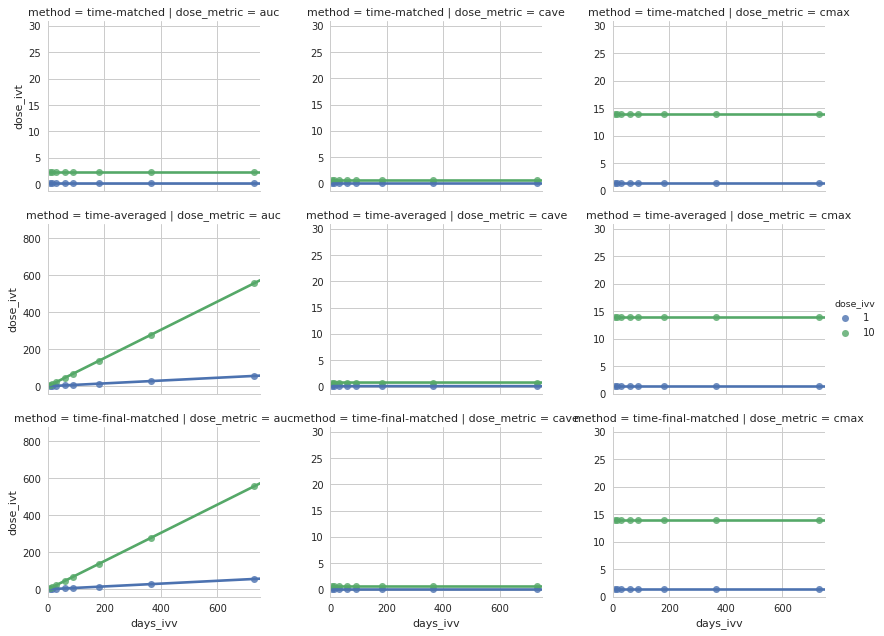

In [60]:
g = sns.lmplot('days_ivv','dose_ivt',
               IV1[IV1.days_ivt==3],
           col='dose_metric',row='method',
           hue='dose_ivv',
           fit_reg=True,lowess=True,x_ci=None,
           size=3,aspect=1.3,
           sharey=False
          )
g.set(xlim=[0,750])

In [62]:
IVd = getIVIVEdata('94-75-7',species='Rat',days_ivt=1,days_ivv=365,
                   dose_metric='cmax',
                   dbc_iviv=HCI.heprn_iviv)
IVd.head()

,name,dsstox_sid,casrn,days_ivt,days_ivv,dose_ivt,dose_ivv,dose_metric,method,species
4890,"2,4-Dichlorophenoxyacetic acid",DTXSID0020442,94-75-7,1.0,365,0.02,1.00e-03,cmax,time-matched,Rat
4891,"2,4-Dichlorophenoxyacetic acid",DTXSID0020442,94-75-7,1.0,365,0.04,1.00e-03,cmax,time-averaged,Rat
4892,"2,4-Dichlorophenoxyacetic acid",DTXSID0020442,94-75-7,1.0,365,0.04,1.00e-03,cmax,time-final-matched,Rat
5220,"2,4-Dichlorophenoxyacetic acid",DTXSID0020442,94-75-7,1.0,365,0.22,1.00e-02,cmax,time-matched,Rat
5221,"2,4-Dichlorophenoxyacetic acid",DTXSID0020442,94-75-7,1.0,365,0.36,1.00e-02,cmax,time-averaged,Rat


In [77]:
calcAED('103-90-2',species='Rat',days_ivt=3,days_ivv=90,
        dose_ivt=np.array([0.1,10,200]),dose_metric='cmax',
        dbc_iviv=HCI.heprn_iviv)

array([  8.27649640e-02,   8.27649642e+00,   1.65529928e+02])

# Run pbtk simulations 

## Serial

In [ ]:
import datetime
HCI.heprn_iviv.drop()

print "Start ... ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

for casrn in getChemInfo():
    print casrn
    simIVIVEdata(casrn,species='Rat',
                OD=[1e-3,1e-2,1e-1,1,10,100,1e6],
                IVt_days=[1.0/24,2.0/24,3.0/24,6.0/24,12.0/24,18.0/24,1,2,3,4,5,6,7],
                IVv_days=[2,7,14,30,60,90,182,365,730],
                rest_clear=False,
                dbc_sav=HCI.heprn_iviv, 
                replace=False
               )

print "End ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), "tasks = ",len(WORK0)
    

In [110]:
HCI.heprn_iviv.count_documents({})

97

In [114]:
CH0 = pd.DataFrame(list(HCI.chemicals.find({},dict(_id=0,casrn=1,name=1,dsstox_sid=1,sample_id=1))))

In [115]:
for i,C in CH0.iterrows():
    IV = HCI.heprn_iviv.find_one(dict(casrn=C.casrn),dict(ivivd=0))
    if IV:
        HCI.heprn_iviv.update_one(dict(_id=IV['_id']),
                                  {'$set':C.to_dict()})

In [ ]:
IVd = getIVIVEdata('Bisphenol A',species='Rat',days_ivt=2,days_ivv=365,
                   dose_metric='cave',
                   dbc_iviv=HCI.heprn_iviv)
IVd

In [117]:
calcAED('Bisphenol A',species='Rat',days_ivt=2,days_ivv=365,
        dose_ivt=np.array([0.1,0.02,3,100]),
        dose_metric='auc',method='time-final-matched',
        dbc_iviv=HCI.heprn_iviv)

array([0.001     , 0.001     , 0.0018743 , 0.06247653])

In [67]:
np.array([6],dtype=np.float)

array([ 6.])

In [78]:
from tk.httk import *

X = calcAllAED('Acetaminophen',species='Rat',days_ivt=3,days_ivv=365,
               css=True,
        dose_ivt=np.array([0.1,0.02,3,100]),
        dbc_iviv=HCI.heprn_iviv)
X.head()

,aed,casrn,days_ivt,days_ivv,dose_ivt,dose_metric,dsstox_sid,ivive_method,name
0,1.31e-02,103-90-2,3,365,0.10,auc,DTXSID2020006,time-averaged,Acetaminophen
1,2.62e-03,103-90-2,3,365,0.02,auc,DTXSID2020006,time-averaged,Acetaminophen
2,3.93e-01,103-90-2,3,365,3.00,auc,DTXSID2020006,time-averaged,Acetaminophen
3,1.31e+01,103-90-2,3,365,100.00,auc,DTXSID2020006,time-averaged,Acetaminophen
0,1.61e+00,103-90-2,3,365,0.10,cave,DTXSID2020006,time-averaged,Acetaminophen


In [80]:
Y = X.pivot_table(index=['name','days_ivt','days_ivv','ivive_method','dose_metric'],
              columns='dose_ivt',
              values='aed')

Y


dose_ivt                                                          0.02    \
name          days_ivt days_ivv ivive_method       dose_metric             
Acetaminophen 3        365      css                q0.05        3.83e-01   
                                                   q0.50        2.51e-01   
                                                   q0.95        1.34e-01   
                                time-averaged      auc          2.62e-03   
                                                   cave         3.22e-01   
                                                   cmax         1.66e-02   
                                time-final-matched auc          2.62e-03   
                                                   cave         3.22e-01   
                                                   cmax         1.66e-02   
                                time-matched       auc          3.19e-01   
                                                   cave         3.22e-01   
                                                   cmax         1.66e-02   

dose_ivt                                                        0.10    \
name          days_ivt days_ivv ivive_method       dose_metric           
Acetaminophen 3        365      css                q0.05          1.92   
                                                   q0.50          1.26   
                                                   q0.95          0.67   
                                time-averaged      auc            0.01   
                                                   cave           1.61   
                                                   cmax           0.08   
                                time-final-matched auc            0.01   
                                                   cave           1.61   
                                                   cmax           0.08   
                                time-matched       auc            1.59   
                                                   cave           1.61   
                                                   cmax           0.08   

dose_ivt                                                        3.00    \
name          days_ivt days_ivv ivive_method       dose_metric           
Acetaminophen 3        365      css                q0.05         57.45   
                                                   q0.50         37.66   
                                                   q0.95         20.05   
                                time-averaged      auc            0.39   
                                                   cave          48.28   
                                                   cmax           2.48   
                                time-final-matched auc            0.39   
                                                   cave          48.27   
                                                   cmax           2.48   
                                time-matched       auc           47.78   
                                                   cave          48.27   
                                                   cmax           2.48   

dose_ivt                                                         100.00  
name          days_ivt days_ivv ivive_method       dose_metric           
Acetaminophen 3        365      css                q0.05        1915.09  
                                                   q0.50        1255.27  
                                                   q0.95         668.25  
                                time-averaged      auc            13.09  
                                                   cave         1000.00  
                                                   cmax           82.76  
                                time-final-matched auc            13.09  
                                                   cave         1000.00  
                                                   cmax           82.76  
                                time-matched   

In [81]:
HCI.heprn_cr.find_one().keys()

dict_keys(['_id', 'ft_ch', 'ch', 'ft', 'name', 'cr_info', 'ft_type', 'timeh', 'fits', 'cr_data', 'data', 'best_fit', 'bmds'])

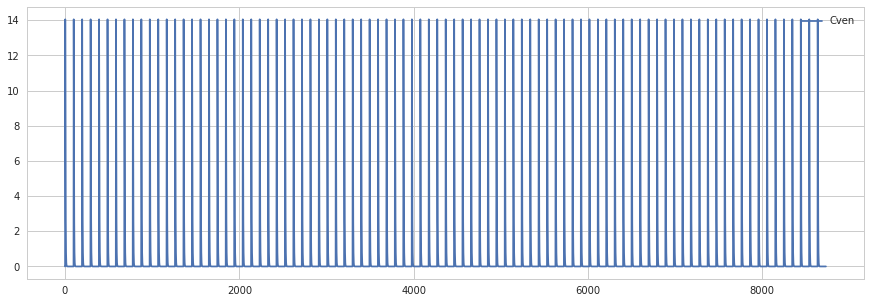

In [84]:
Y1 = solvePBTK('103-90-2',days=90,dose=10,species='Rat',rest_clear=True)#.set_index('time')

Y1[['Cven']].plot(figsize=(15,5))
#x1=Y1[Y1.time>=79].index.min()
#x2=Y1[Y1.time>=80].index.min()
for i in [87,88,89,90]:
    pl.vlines([i],0,Y1.loc[i:90].Cven.max(),'r')
pl.vlines([0,1],0,Y1.loc[89:90].Cven.max(),'g')

In [86]:
Y1.head()

,time,Agutlumen,Cart,Cven,Clung,Cgut,Cliver,Ckidney,Crest,Ametabolized,Atubules,Cplasma,AUC
0,0.00e+00,16.54,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
1,1.00e-08,16.54,1.87e-25,1.91e-14,8.54e-18,1.34e-03,6.47e-09,7.44e-31,4.08e-32,1.49e-16,6.18e-43,1.91e-14,9.54e-23
2,1.04e-02,9.59,1.19e+01,1.19e+01,1.90e+01,8.10e+01,8.24e+01,3.86e+01,9.50e+00,3.61e+00,9.48e-02,1.19e+01,7.47e-02
3,2.08e-02,5.56,1.40e+01,1.40e+01,2.24e+01,5.93e+01,6.25e+01,4.65e+01,1.29e+01,7.10e+00,2.87e-01,1.40e+01,2.15e-01
4,3.12e-02,3.22,1.26e+01,1.26e+01,2.00e+01,4.21e+01,4.53e+01,4.19e+01,1.20e+01,9.69e+00,4.81e-01,1.26e+01,3.55e-01


# For max conc calculations

In [4]:
%%R
suppressMessages(library(httk))

In [ ]:
import datetime
from tk.httk import *
print("Start ... ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
HCI.heprn_iviv_max.drop()
for casrn in getChemInfo():
    print(casrn)
    simIVIVEdata(str(casrn),species='Rat',
                OD=[1e-3,1e6],
                IVt_days=[1],
                IVv_days=[90,730],
                rest_clear=False,
                dbc_sav=HCI.heprn_iviv_max, 
                replace=False
               )

print("End ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    

Start ...  2020-06-18 23:38:06
94-75-7
34256-82-1
DLSODA-  Warning..Internal T (=R1) and H (=R2) are
      such that in the machine, T + H = T on the next step  
     (H = step size). Solver will continue anyway.
In above message, R1 = 512, R2 = 4.59153e-14
 
DLSODA-  Warning..Internal T (=R1) and H (=R2) are
      such that in the machine, T + H = T on the next step  
     (H = step size). Solver will continue anyway.
In above message, R1 = 512, R2 = 4.59153e-14
 
DLSODA-  Warning..Internal T (=R1) and H (=R2) are
      such that in the machine, T + H = T on the next step  
     (H = step size). Solver will continue anyway.
In above message, R1 = 513, R2 = 4.59153e-14
 
DLSODA-  Warning..Internal T (=R1) and H (=R2) are
      such that in the machine, T + H = T on the next step  
     (H = step size). Solver will continue anyway.
In above message, R1 = 513, R2 = 4.59153e-14
 
DLSODA-  Warning..Internal T (=R1) and H (=R2) are
      such that in the machine, T + H = T on the next step 

In [7]:
HCI.heprn_iviv_max.count_documents({})

97

In [8]:
HCI.heprn_iviv_max.find_one()

{'_id': ObjectId('5eec3324cf17a68b51f2737e'),
 'casrn': '94-75-7',
 'species': 'Rat',
 'rest_clear': False,
 'doses_per_day': 1,
 'ivt_units': 'uM',
 'oral_doses': [0.001, 1000000.0],
 'invitro_days': [1],
 'invivo_days': [90, 730],
 'ivivd': [{'casrn': '94-75-7',
   'species': 'Rat',
   'days_ivt': 1,
   'days_ivv': 90,
   'dose_ivv': 0.001,
   'method': 'time-matched',
   'dose_metric': 'auc',
   'dose_ivt': 0.007106939428575856},
  {'casrn': '94-75-7',
   'species': 'Rat',
   'days_ivt': 1,
   'days_ivv': 90,
   'dose_ivv': 0.001,
   'method': 'time-averaged',
   'dose_metric': 'auc',
   'dose_ivt': 1.07472728579176},
  {'casrn': '94-75-7',
   'species': 'Rat',
   'days_ivt': 1,
   'days_ivv': 90,
   'dose_ivv': 0.001,
   'method': 'time-final-matched',
   'dose_metric': 'auc',
   'dose_ivt': 1.07472728579176},
  {'casrn': '94-75-7',
   'species': 'Rat',
   'days_ivt': 1,
   'days_ivv': 730,
   'dose_ivv': 0.001,
   'method': 'time-matched',
   'dose_metric': 'auc',
   'dose_ivt': 0